# Exploratory Data Analysis

### 1. Loading Data

In [1]:
import pandas as pd

train = pd.read_csv(r"C:\Users\YILMAZ\Desktop\appartments_train.csv")
test = pd.read_csv(r"C:\Users\YILMAZ\Desktop\appartments_test.csv")

### 2. Dataset Overview

In [4]:
print(train.shape)

(156454, 34)


In [3]:
print(train.dtypes)

unit_id                        object
obj_type                       object
dim_m2                        float64
n_rooms                       float64
floor_no                      float64
floor_max                     float64
year_built                    float64
dist_centre                   float64
n_poi                         float64
dist_sch                      float64
dist_clinic                   float64
dist_post                     float64
dist_kind                     float64
dist_rest                     float64
dist_uni                      float64
dist_pharma                   float64
own_type                       object
build_mat                      object
cond_class                     object
has_park                       object
has_balcony                    object
has_lift                       object
has_sec                        object
has_store                      object
price_z                       float64
src_month                      object
loc_code    

In [5]:
print(train.describe(include='all').T)

                               count unique               top    freq  \
unit_id                       156454  82491  ff92f050e0b9869f      11   
obj_type                      122634      3          0d6c4dfc   73136   
dim_m2                      156454.0    NaN               NaN     NaN   
n_rooms                     156454.0    NaN               NaN     NaN   
floor_no                    128756.0    NaN               NaN     NaN   
floor_max                   154533.0    NaN               NaN     NaN   
year_built                  130741.0    NaN               NaN     NaN   
dist_centre                 156454.0    NaN               NaN     NaN   
n_poi                       156454.0    NaN               NaN     NaN   
dist_sch                    156324.0    NaN               NaN     NaN   
dist_clinic                 155883.0    NaN               NaN     NaN   
dist_post                   156266.0    NaN               NaN     NaN   
dist_kind                   156291.0    NaN        

•	unit_id – Unique ID: There are many repetitions (freq = 11), suggesting that observations are not purely apartment-level; possibly the same apartment is recorded at different time points.

•	src_month – Time attribute: 11 distinct months; seasonal effects might be present. Time series influence can be considered.

•	loc_code – Location code (anonymized): 15 unique locations. This could be an important categorical predictor.

•	dim_m2, n_rooms – Core size indicators. dim_m2 ranges from 18.78 to 187.31 → outlier detection is recommended.

•	floor_no, floor_max – Some missing values (e.g., floor_no has ~17% missing). Check for inconsistencies like floor_no > floor_max.

•	year_built – Ranges from 1850 to 2024. Should be interpreted alongside infrastructure_quality. Missing in ~17% of rows.

•	estimated_maintenance_cost – Likely highly correlated with dim_m2. If correlation is too high, one may be dropped.

•	dist_centre, dist_sch, dist_clinic, ... – All are positive and have low means, suggesting that most apartments are near city centers or POIs. Max values >5 km → consider outlier treatment or log-transformation.

•	green_space_ratio – Very low variance (mean ≈ 1, std ≈ 0.0005) → may contribute little to modeling and act almost like a constant.

•	obj_type, own_type, build_mat, cond_class – All are anonymized categorical variables. Some have serious missingness: for example, cond_class appears in only 39K out of 156K rows (~75% missing). Analyze before deciding to drop/impute/use.

•	has_park, has_balcony, has_lift, has_sec, has_store – Coded as 'yes' / 'no'. has_lift has about 5% missing values; the rest are complete. These should be converted to binary using map({'yes': 1, 'no': 0}). Some features might be rare → treat with caution.

•	market_volatility, global_economic_index – Might be highly correlated with the target variable (price_z). Especially market_volatility shows a near-identical distribution → strong correlation may cause target leakage if not handled properly.

•	popularity_index, neighborhood_crime_rate, infrastructure_quality – Distributions are reasonable. popularity_index appears normally distributed.

•	infrastructure_quality – Has ~17% missing values → use carefully in modeling.


### 3. Missing Value Analysis

In [6]:
missing_values = train.isna().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("Missing values:\n", missing_values)

Missing values:
 cond_class                117058
build_mat                  61999
obj_type                   33820
floor_no                   27698
year_built                 25713
infrastructure_quality     25713
has_lift                    7727
dist_uni                    4317
floor_max                   1921
dist_clinic                  571
dist_rest                    391
dist_pharma                  219
dist_post                    188
dist_kind                    163
dist_sch                     130
dtype: int64


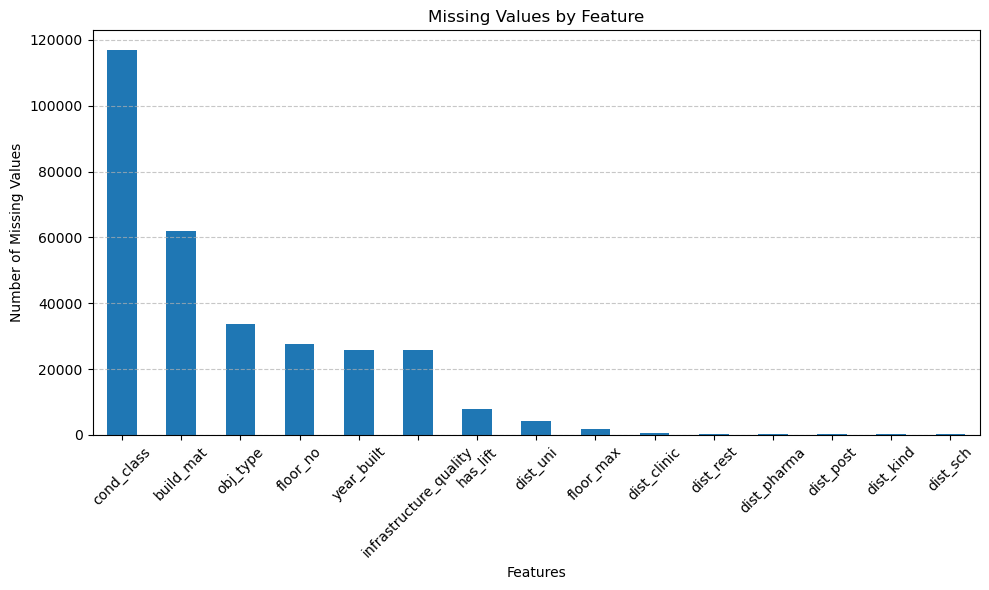

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
missing_values.plot(kind='bar')
plt.title('Missing Values by Feature')
plt.xlabel('Features')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

•	cond_class (~75%) → Too much missing; should be dropped or encoded as "unknown".

•	build_mat (~40%) → Can be handled with a "missing" category.

•	obj_type (~21%) → Borderline missingness; can be used with a "missing" label, but importance should be evaluated.

•	floor_no (~17%) → Can be inputted with -1 or treated as "unknown".

•	year_built & infrastructure_quality (~16%) → Jointly missing; impute with median or add a binary "missing_quality" flag.

•	has_lift (~5%) → Impute with mode or create an "unknown" category.

•	dist_uni, floor_max, dist_* variables → Low risk; safe to fill with median values.


### 4. Distribution of Numerical Variables

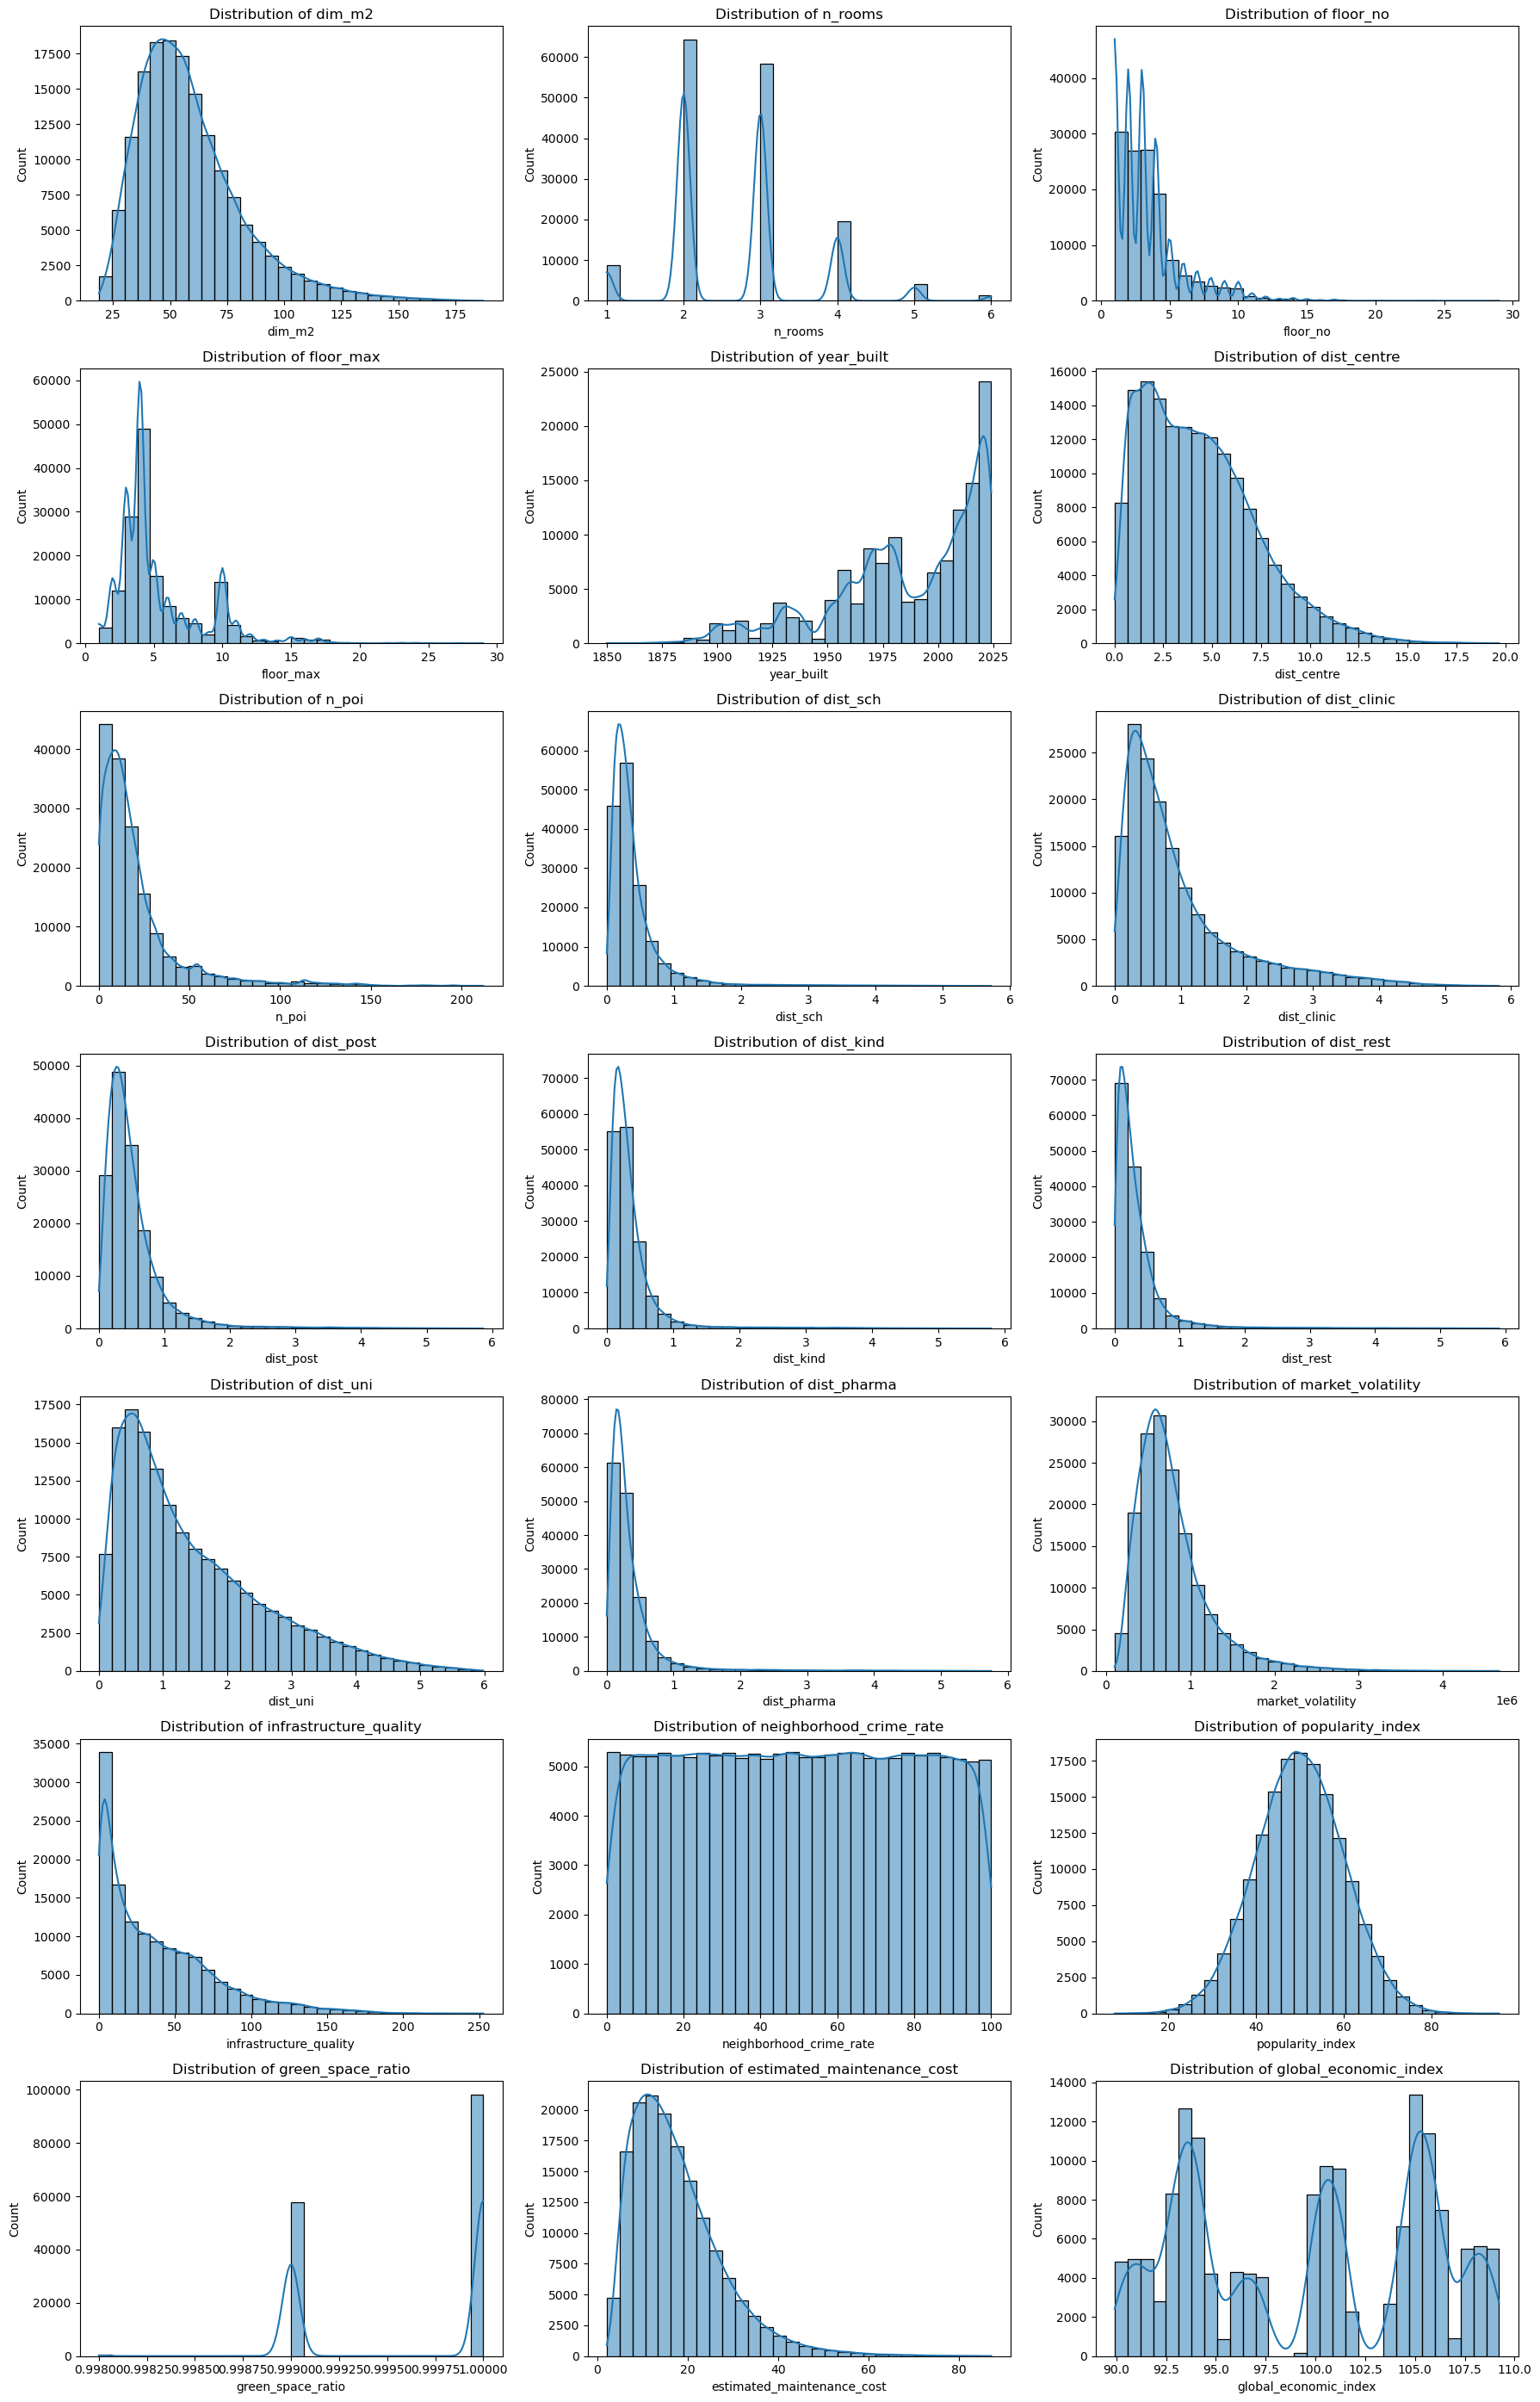

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

numerical_cols = train.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_cols.remove('price_z')

n_cols = 3
n_rows = math.ceil(len(numerical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()  

for i, col in enumerate(numerical_cols):
    sns.histplot(train[col], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 5. Relationship between Numerical Variables and Target Variable

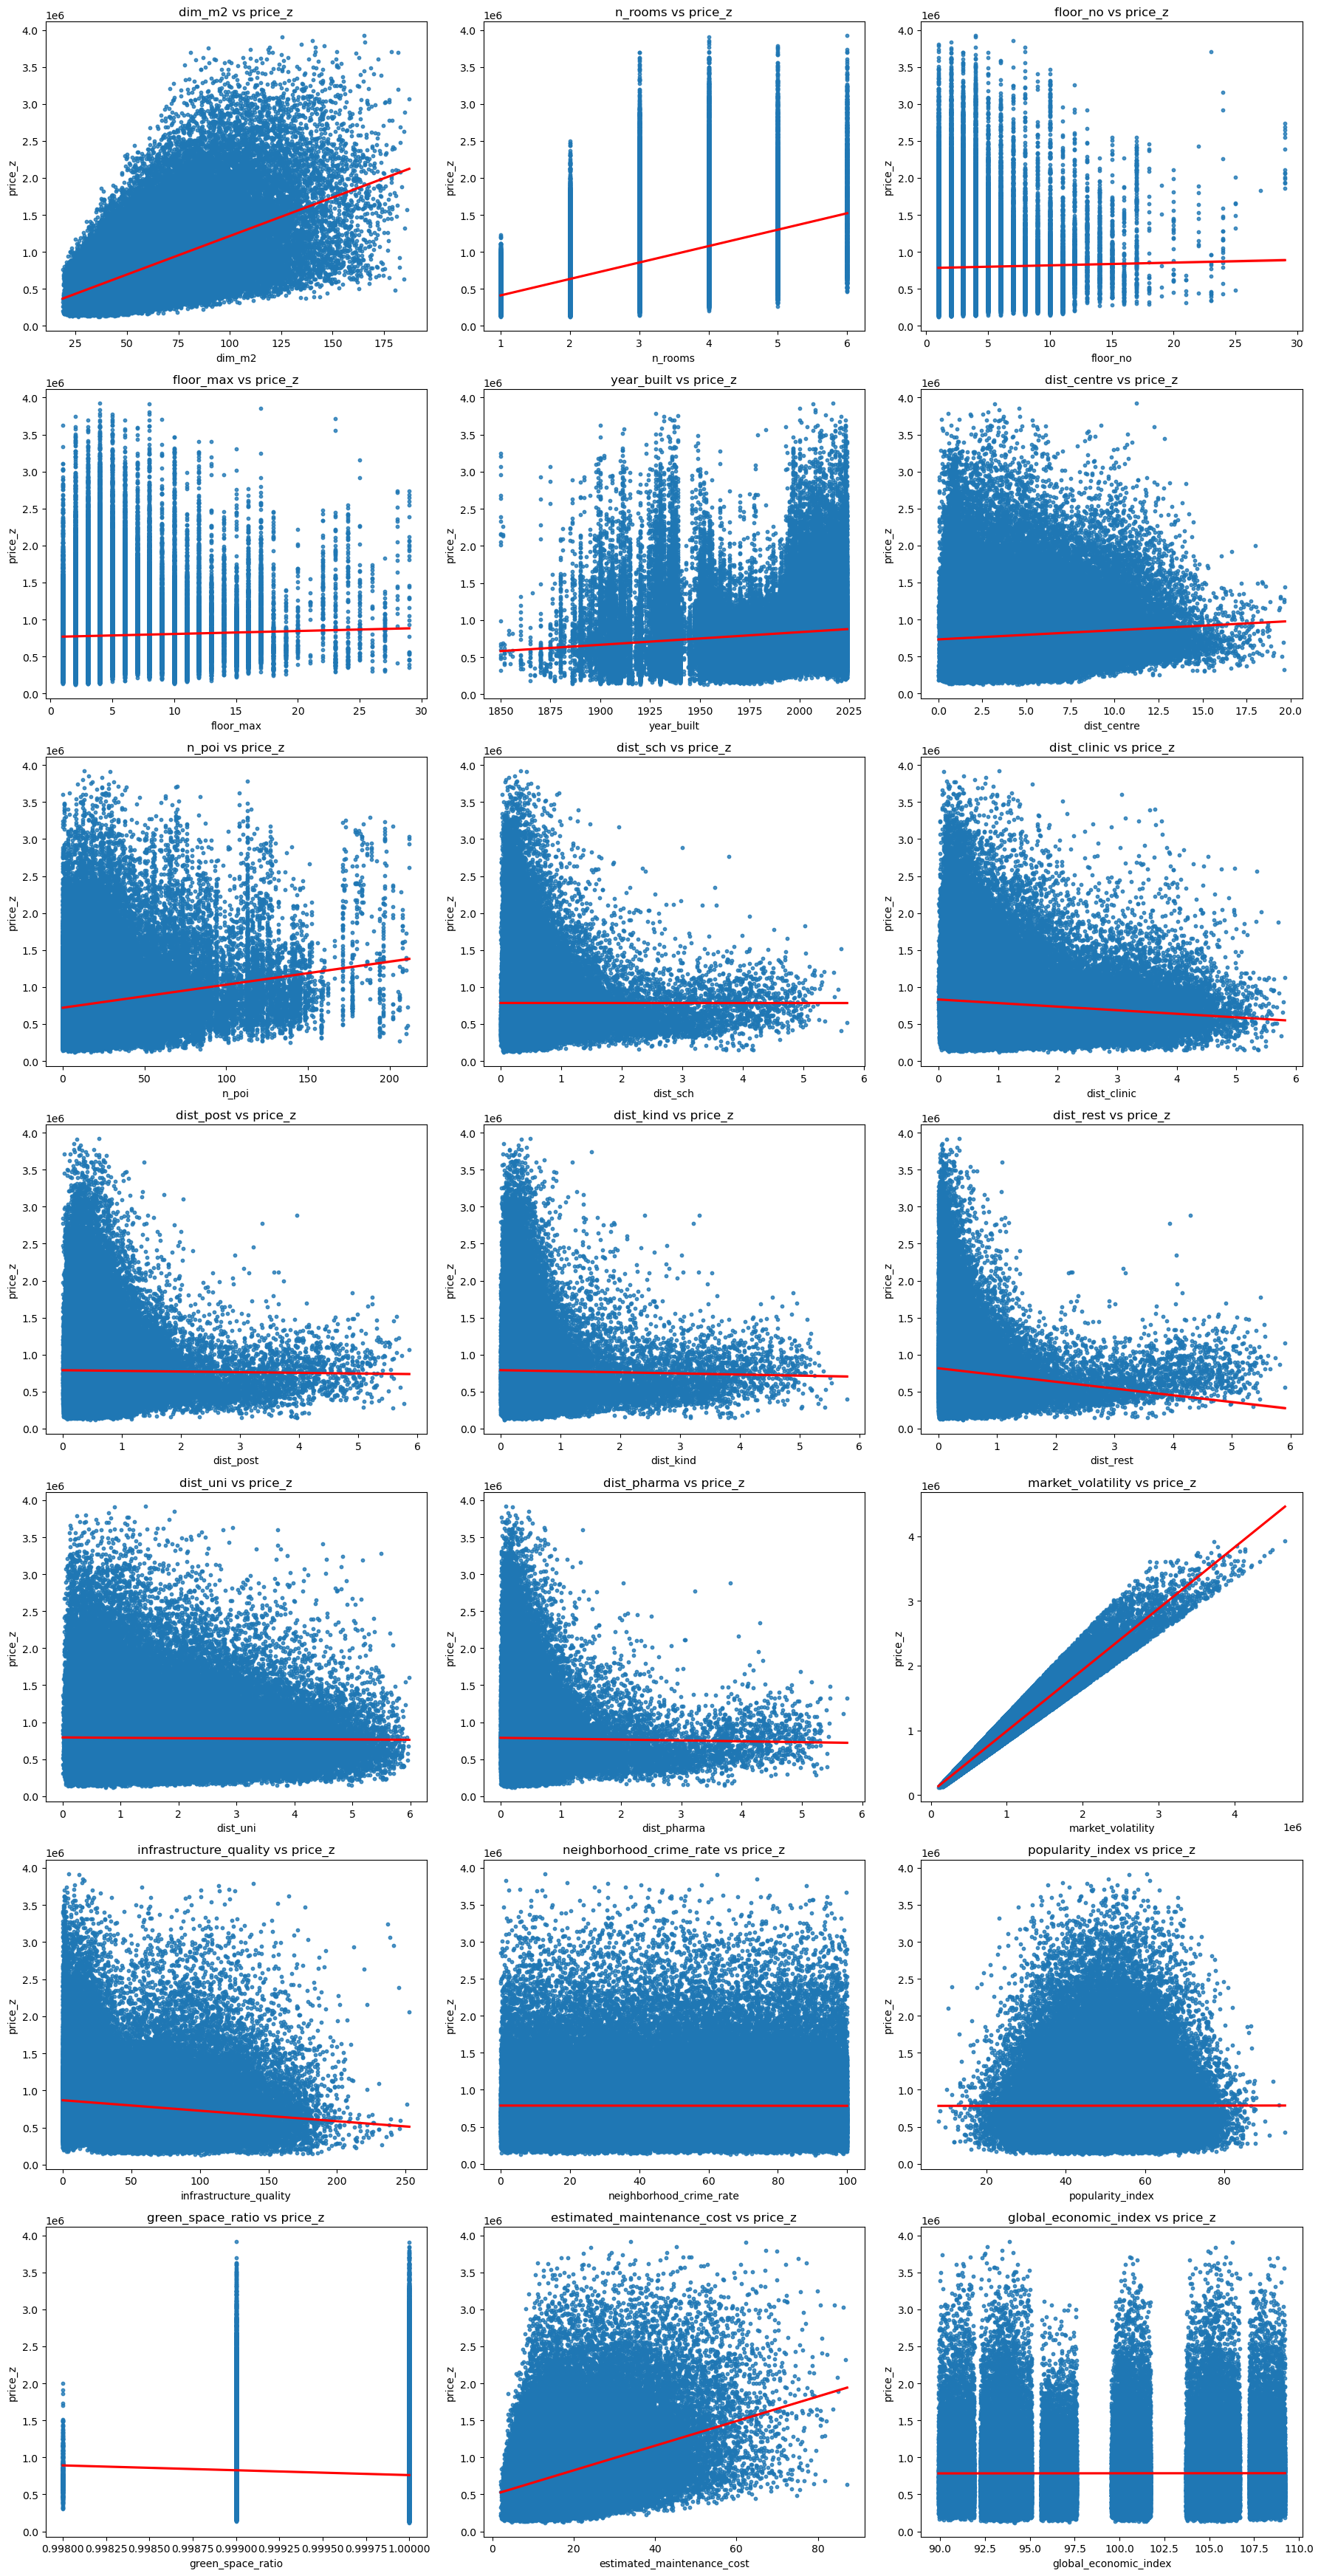

In [11]:
numerical_cols = train.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_cols.remove('price_z')

n_cols = 3
n_rows = math.ceil(len(numerical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.regplot(x=train[col], y=train['price_z'], ax=axes[i], scatter_kws={'s': 10}, line_kws={'color': 'red'})
    axes[i].set_title(f'{col} vs price_z')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Correlation Matrix

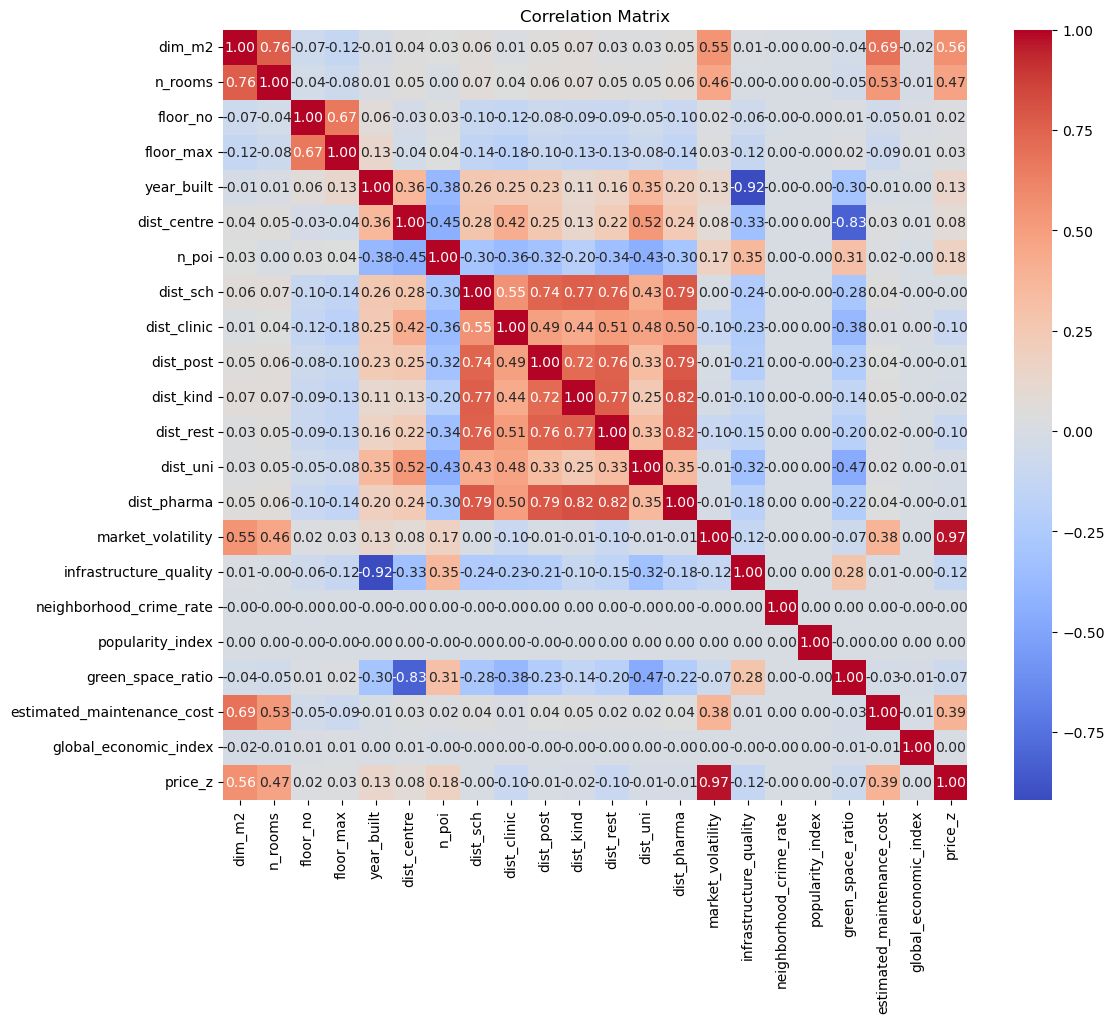

In [12]:
correlation = train[numerical_cols + ['price_z']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

•	dim_m2, n_rooms, estimated_maintenance_cost – Due to high multicollinearity, feature selection is recommended.
    
•	market_volatility – Extremely strong correlation with the target → high risk of target leakage. Should be excluded or carefully normalized.

•	Low-impact features – Variables like green_space_ratio, global_economic_index, and popularity_index should be evaluated for importance before inclusion.

•	Feature Engineering – New features such as age = 2025 - year_built and floor_ratio = floor_no / floor_max can provide meaningful insights.


In [13]:
print(correlation)

                              dim_m2   n_rooms  floor_no  floor_max  \
dim_m2                      1.000000  0.763365 -0.067677  -0.123550   
n_rooms                     0.763365  1.000000 -0.035823  -0.078455   
floor_no                   -0.067677 -0.035823  1.000000   0.665670   
floor_max                  -0.123550 -0.078455  0.665670   1.000000   
year_built                 -0.013937  0.005164  0.064715   0.126588   
dist_centre                 0.042232  0.051075 -0.025474  -0.039538   
n_poi                       0.034440  0.002756  0.032439   0.040917   
dist_sch                    0.062255  0.067386 -0.101636  -0.139826   
dist_clinic                 0.013766  0.039393 -0.121444  -0.176904   
dist_post                   0.053453  0.060387 -0.075030  -0.104399   
dist_kind                   0.066972  0.065115 -0.090331  -0.129294   
dist_rest                   0.031716  0.051771 -0.086864  -0.127848   
dist_uni                    0.031970  0.047288 -0.052271  -0.078968   
dist_p

### 7. Relationship of Categorical Variables with Target Variable

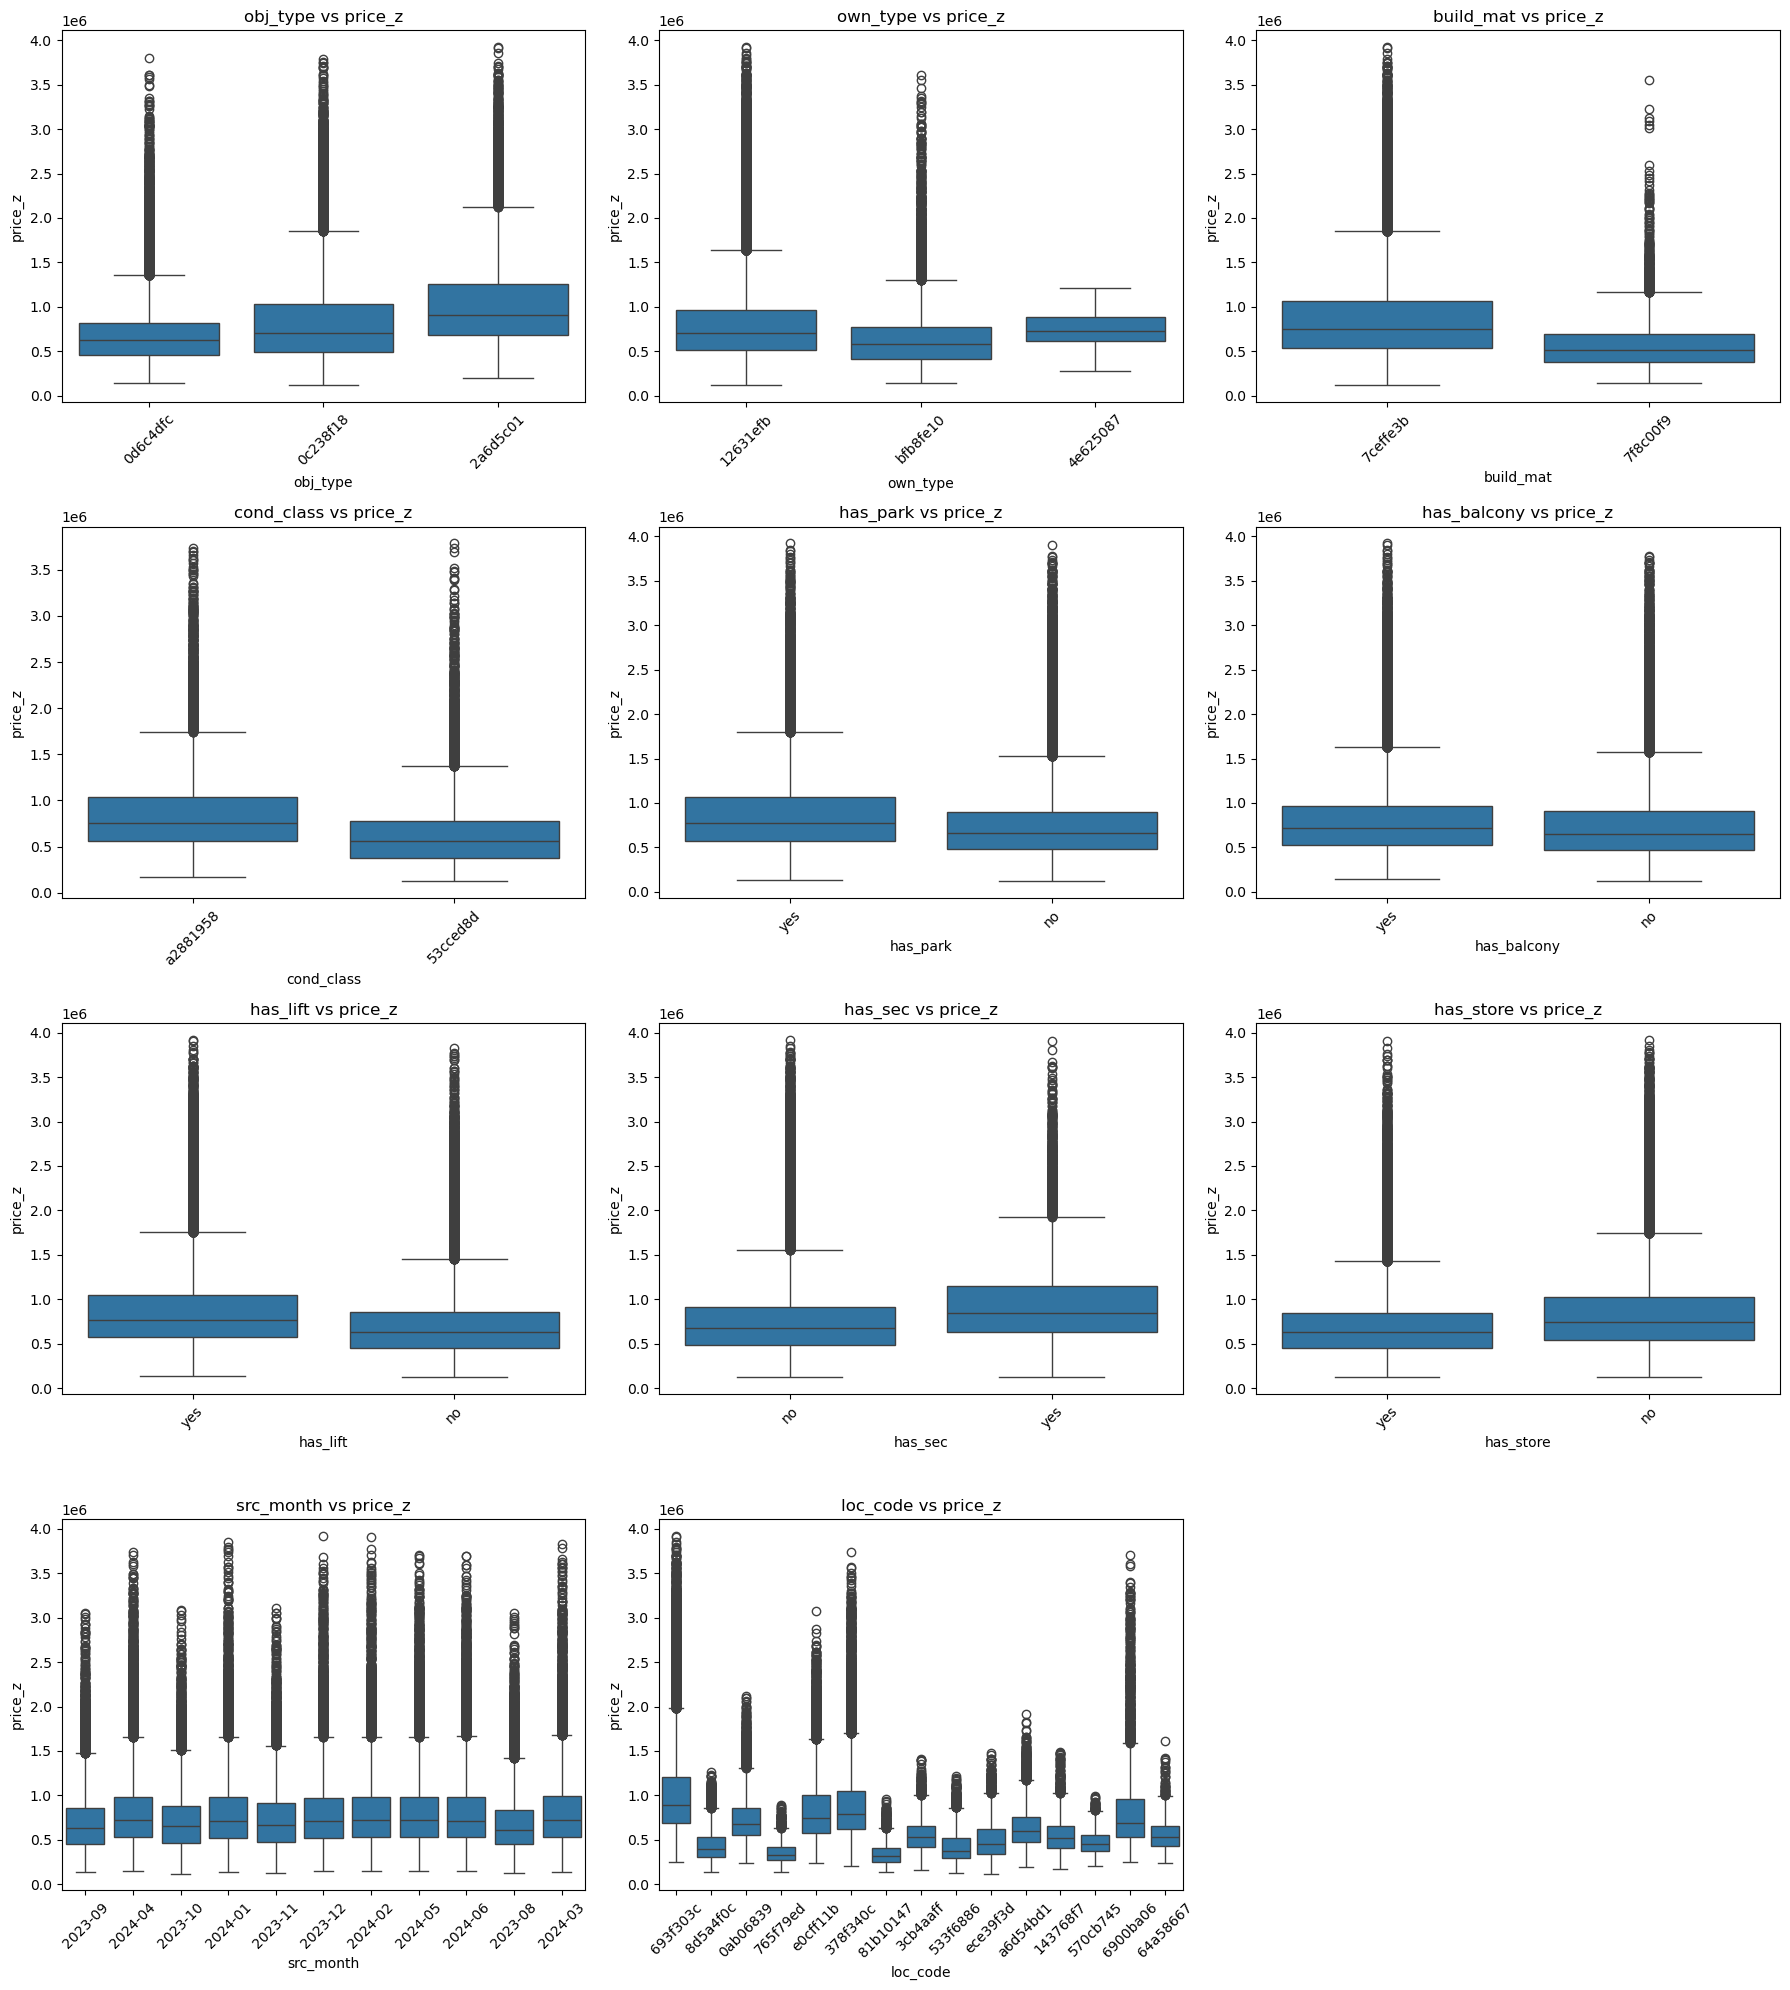

In [14]:
categorical_cols = train.select_dtypes(include=['object', 'bool']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'unit_id']

n_cols = 3
n_rows = math.ceil(len(categorical_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.boxplot(x=col, y='price_z', data=train, ax=axes[i])
    axes[i].set_title(f'{col} vs price_z')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 8. Outlier Analysis – IQR and Z-score

In [15]:
from scipy.stats import zscore

z_scores = train[numerical_cols].apply(zscore)
outlier_zscore = (z_scores.abs() > 3).sum()

outlier_iqr = {}
for col in numerical_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    is_outlier = (train[col] < (Q1 - 1.5 * IQR)) | (train[col] > (Q3 + 1.5 * IQR))
    outlier_iqr[col] = is_outlier.sum()

print("Outliers (Z-score):\n", outlier_zscore.sort_values(ascending=False))
print("Outliers (IQR):\n", pd.Series(outlier_iqr).sort_values(ascending=False))


Outliers (Z-score):
 n_poi                         4171
market_volatility             2956
dim_m2                        2359
estimated_maintenance_cost    2252
n_rooms                       1300
dist_centre                   1274
popularity_index               430
green_space_ratio              358
dist_uni                         0
neighborhood_crime_rate          0
infrastructure_quality           0
dist_pharma                      0
dist_kind                        0
dist_rest                        0
dist_post                        0
dist_clinic                      0
dist_sch                         0
year_built                       0
floor_max                        0
floor_no                         0
global_economic_index            0
dtype: int64
Outliers (IQR):
 n_poi                         14199
dist_sch                      11944
dist_clinic                   11731
dist_pharma                   10943
floor_max                     10897
dist_kind                     1009